# Convolutional Neural Network

This example shows how to design a simple CNN.

We also show the impact of quantization on accuracy and lastly how to run the model in FHE.

### Import required modules

In [1]:
import time

import numpy as np
import torch
import torch.utils
from concrete.compiler import check_gpu_available
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from concrete.ml.torch.compile import compile_torch_model

# And some helpers for visualization.

%matplotlib inline

import matplotlib.pyplot as plt

### Load the data-set and visualize it

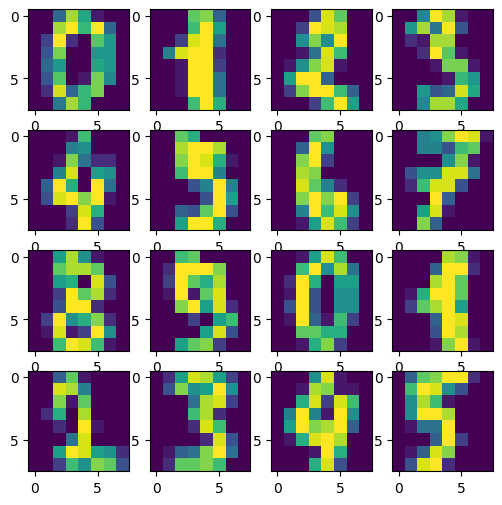

In [2]:
X, y = load_digits(return_X_y=True)

# The sklearn Digits data-set, though it contains digit images, keeps these images in vectors
# so we need to reshape them to 2D first. The images are 8x8 px in size and monochrome
X = np.expand_dims(X.reshape((-1, 8, 8)), 1)

nplot = 4
fig, ax = plt.subplots(nplot, nplot, figsize=(6, 6))
for i in range(0, nplot):
    for j in range(0, nplot):
        ax[i, j].imshow(X[i * nplot + j, ::].squeeze())
plt.show()

x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=42
)

### Define the neural network

In [3]:
class TinyCNN(nn.Module):
    """A very small CNN to classify the sklearn digits data-set."""

    def __init__(self, n_classes) -> None:
        """Construct the CNN with a configurable number of classes."""
        super().__init__()

        # This network has a total complexity of 1216 MAC
        self.conv1 = nn.Conv2d(1, 8, 3, stride=1, padding=0)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(16, 32, 2, stride=1, padding=0)
        self.fc1 = nn.Linear(32, n_classes)

    def forward(self, x):
        """Run inference on the tiny CNN, apply the decision layer on the reshaped conv output."""
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = x.flatten(1)
        x = self.fc1(x)
        return x

### Train the CNN


Training:   0%|                                                                                                  | 0/150 [00:00<?, ?it/s]


Training:   3%|██▍                                                                                       | 4/150 [00:00<00:04, 36.04it/s]


Training:   6%|█████▍                                                                                    | 9/150 [00:00<00:03, 43.86it/s]


Training:   9%|████████▎                                                                                | 14/150 [00:00<00:02, 46.46it/s]


Training:  13%|███████████▎                                                                             | 19/150 [00:00<00:02, 46.89it/s]


Training:  16%|██████████████▏                                                                          | 24/150 [00:00<00:02, 47.78it/s]


Training:  19%|█████████████████▏                                                                       | 29/150 [00:00<00:02, 48.24it/s]


Training:  23%|████████████████████▏                                                                    | 34/150 [00:00<00:02, 48.55it/s]


Training:  26%|███████████████████████▏                                                                 | 39/150 [00:00<00:02, 48.83it/s]


Training:  29%|██████████████████████████                                                               | 44/150 [00:00<00:02, 49.05it/s]


Training:  33%|█████████████████████████████                                                            | 49/150 [00:01<00:02, 48.53it/s]


Training:  36%|████████████████████████████████                                                         | 54/150 [00:01<00:01, 48.77it/s]


Training:  39%|███████████████████████████████████                                                      | 59/150 [00:01<00:01, 49.01it/s]


Training:  43%|█████████████████████████████████████▉                                                   | 64/150 [00:01<00:01, 49.09it/s]


Training:  46%|████████████████████████████████████████▉                                                | 69/150 [00:01<00:01, 49.16it/s]


Training:  49%|███████████████████████████████████████████▉                                             | 74/150 [00:01<00:01, 49.21it/s]


Training:  53%|██████████████████████████████████████████████▊                                          | 79/150 [00:01<00:01, 49.25it/s]


Training:  56%|█████████████████████████████████████████████████▊                                       | 84/150 [00:01<00:01, 49.31it/s]


Training:  59%|████████████████████████████████████████████████████▊                                    | 89/150 [00:01<00:01, 49.38it/s]


Training:  63%|███████████████████████████████████████████████████████▊                                 | 94/150 [00:01<00:01, 49.47it/s]


Training:  66%|██████████████████████████████████████████████████████████▋                              | 99/150 [00:02<00:01, 49.60it/s]


Training:  69%|█████████████████████████████████████████████████████████████                           | 104/150 [00:02<00:00, 49.60it/s]


Training:  73%|███████████████████████████████████████████████████████████████▉                        | 109/150 [00:02<00:00, 49.66it/s]


Training:  76%|██████████████████████████████████████████████████████████████████▉                     | 114/150 [00:02<00:00, 49.66it/s]


Training:  79%|█████████████████████████████████████████████████████████████████████▊                  | 119/150 [00:02<00:00, 49.64it/s]


Training:  83%|████████████████████████████████████████████████████████████████████████▋               | 124/150 [00:02<00:00, 49.61it/s]


Training:  86%|███████████████████████████████████████████████████████████████████████████▋            | 129/150 [00:02<00:00, 49.55it/s]


Training:  89%|██████████████████████████████████████████████████████████████████████████████▌         | 134/150 [00:02<00:00, 49.55it/s]


Training:  93%|█████████████████████████████████████████████████████████████████████████████████▌      | 139/150 [00:02<00:00, 49.10it/s]


Training:  96%|████████████████████████████████████████████████████████████████████████████████████▍   | 144/150 [00:02<00:00, 49.35it/s]


Training:  99%|███████████████████████████████████████████████████████████████████████████████████████▍| 149/150 [00:03<00:00, 49.47it/s]


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:03<00:00, 48.85it/s]

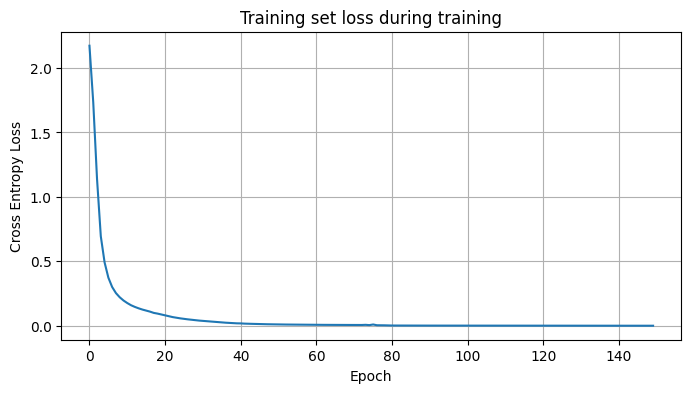

In [4]:
torch.manual_seed(42)


def train_one_epoch(net, optimizer, train_loader):
    # Cross Entropy loss for classification when not using a softmax layer in the network
    loss = nn.CrossEntropyLoss()

    net.train()
    avg_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = net(data)
        loss_net = loss(output, target.long())
        loss_net.backward()
        optimizer.step()
        avg_loss += loss_net.item()

    return avg_loss / len(train_loader)


# Create the tiny CNN with 10 output classes
N_EPOCHS = 150

# Create a train data loader
train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=64)

# Create a test data loader to supply batches for network evaluation (test)
test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset)

# Train the network with Adam, output the test set accuracy every epoch
net = TinyCNN(10)
losses_bits = []
optimizer = torch.optim.Adam(net.parameters())
for _ in tqdm(range(N_EPOCHS), desc="Training"):
    losses_bits.append(train_one_epoch(net, optimizer, train_dataloader))

fig = plt.figure(figsize=(8, 4))
plt.plot(losses_bits)
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.title("Training set loss during training")
plt.grid(True)
plt.show()

### Test the torch network in fp32

In [5]:
def test_torch(net, test_loader):
    """Test the network: measure accuracy on the test set."""

    # Freeze normalization layers
    net.eval()

    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the batches
    idx = 0
    for data, target in test_loader:
        # Accumulate the ground truth labels
        endidx = idx + target.shape[0]
        all_targets[idx:endidx] = target.numpy()

        # Run forward and get the predicted class id
        output = net(data).argmax(1).detach().numpy()
        all_y_pred[idx:endidx] = output

        idx += target.shape[0]

    # Print out the accuracy as a percentage
    n_correct = np.sum(all_targets == all_y_pred)
    print(
        f"Test accuracy for fp32 weights and activations: "
        f"{n_correct / len(test_loader) * 100:.2f}%"
    )


test_torch(net, test_dataloader)

Test accuracy for fp32 weights and activations: 98.22%


### Define the Concrete ML testing function

We introduce the `test_with_concrete` function which allows us to test a Concrete ML model in one of two modes:
- in FHE
- in the clear, using simulated FHE execution

Note that it is trivial to toggle between between the two modes. 

In [6]:
def test_with_concrete(quantized_module, test_loader, use_sim):
    """Test a neural network that is quantized and compiled with Concrete ML."""

    # Casting the inputs into int64 is recommended
    all_y_pred = np.zeros((len(test_loader)), dtype=np.int64)
    all_targets = np.zeros((len(test_loader)), dtype=np.int64)

    # Iterate over the test batches and accumulate predictions and ground truth labels in a vector
    idx = 0
    for data, target in tqdm(test_loader):
        data = data.numpy()
        target = target.numpy()

        fhe_mode = "simulate" if use_sim else "execute"

        # Quantize the inputs and cast to appropriate data type
        y_pred = quantized_module.forward(data, fhe=fhe_mode)

        endidx = idx + target.shape[0]

        # Accumulate the ground truth labels
        all_targets[idx:endidx] = target

        # Get the predicted class id and accumulate the predictions
        y_pred = np.argmax(y_pred, axis=1)
        all_y_pred[idx:endidx] = y_pred

        # Update the index
        idx += target.shape[0]

    # Compute and report results
    n_correct = np.sum(all_targets == all_y_pred)

    return n_correct / len(test_loader)

### Test the network using Simulation

Note that this is not a test in FHE. The simulated FHE mode gives 
insight about the impact of FHE execution on the accuracy.

The torch neural network is converted to FHE by Concrete ML using a dedicated function, `compile_torch_model`.

In [7]:
n_bits = 6

use_gpu_if_available = False
device = "cuda" if use_gpu_if_available and check_gpu_available() else "cpu"

q_module = compile_torch_model(net, x_train, rounding_threshold_bits=6, p_error=0.1, device=device)

start_time = time.time()
accs = test_with_concrete(
    q_module,
    test_dataloader,
    use_sim=True,
)
sim_time = time.time() - start_time

print(f"Simulated FHE execution for {n_bits} bit network accuracy: {accs:.2f}%")

Compilation device override, was 'cpu' -> change to 'cuda'



  0%|                                                                                                            | 0/450 [00:00<?, ?it/s]


  0%|▏                                                                                                   | 1/450 [00:00<02:07,  3.52it/s]


  2%|█▊                                                                                                  | 8/450 [00:00<00:17, 25.01it/s]


  3%|███▎                                                                                               | 15/450 [00:00<00:11, 38.23it/s]


  5%|████▊                                                                                              | 22/450 [00:00<00:09, 47.05it/s]


  6%|██████▍                                                                                            | 29/450 [00:00<00:07, 52.98it/s]


  8%|███████▉                                                                                           | 36/450 [00:00<00:07, 57.09it/s]


 10%|█████████▍                                                                                         | 43/450 [00:00<00:06, 59.94it/s]


 11%|███████████                                                                                        | 50/450 [00:01<00:06, 61.75it/s]


 13%|████████████▌                                                                                      | 57/450 [00:01<00:06, 63.12it/s]


 14%|██████████████                                                                                     | 64/450 [00:01<00:06, 64.07it/s]


 16%|███████████████▌                                                                                   | 71/450 [00:01<00:05, 64.55it/s]


 17%|█████████████████▏                                                                                 | 78/450 [00:01<00:05, 65.13it/s]


 19%|██████████████████▋                                                                                | 85/450 [00:01<00:05, 65.47it/s]


 20%|████████████████████▏                                                                              | 92/450 [00:01<00:05, 65.68it/s]


 22%|█████████████████████▊                                                                             | 99/450 [00:01<00:05, 65.81it/s]


 24%|███████████████████████                                                                           | 106/450 [00:01<00:05, 65.86it/s]


 25%|████████████████████████▌                                                                         | 113/450 [00:01<00:05, 65.96it/s]


 27%|██████████████████████████▏                                                                       | 120/450 [00:02<00:04, 66.09it/s]


 28%|███████████████████████████▋                                                                      | 127/450 [00:02<00:04, 65.59it/s]


 30%|█████████████████████████████▏                                                                    | 134/450 [00:02<00:04, 65.24it/s]


 31%|██████████████████████████████▋                                                                   | 141/450 [00:02<00:04, 65.53it/s]


 33%|████████████████████████████████▏                                                                 | 148/450 [00:02<00:04, 65.56it/s]


 34%|█████████████████████████████████▊                                                                | 155/450 [00:02<00:04, 65.73it/s]


 36%|███████████████████████████████████▎                                                              | 162/450 [00:02<00:04, 65.82it/s]


 38%|████████████████████████████████████▊                                                             | 169/450 [00:02<00:04, 65.95it/s]


 39%|██████████████████████████████████████▎                                                           | 176/450 [00:02<00:04, 66.05it/s]


 41%|███████████████████████████████████████▊                                                          | 183/450 [00:03<00:04, 66.09it/s]


 42%|█████████████████████████████████████████▍                                                        | 190/450 [00:03<00:03, 66.16it/s]


 44%|██████████████████████████████████████████▉                                                       | 197/450 [00:03<00:03, 66.15it/s]


 45%|████████████████████████████████████████████▍                                                     | 204/450 [00:03<00:03, 65.78it/s]


 47%|█████████████████████████████████████████████▉                                                    | 211/450 [00:03<00:03, 64.85it/s]


 48%|███████████████████████████████████████████████▍                                                  | 218/450 [00:03<00:03, 65.21it/s]


 50%|█████████████████████████████████████████████████                                                 | 225/450 [00:03<00:03, 65.40it/s]


 52%|██████████████████████████████████████████████████▌                                               | 232/450 [00:03<00:03, 65.56it/s]


 53%|████████████████████████████████████████████████████                                              | 239/450 [00:03<00:03, 65.73it/s]


 55%|█████████████████████████████████████████████████████▌                                            | 246/450 [00:04<00:03, 65.75it/s]


 56%|███████████████████████████████████████████████████████                                           | 253/450 [00:04<00:02, 65.77it/s]


 58%|████████████████████████████████████████████████████████▌                                         | 260/450 [00:04<00:02, 65.83it/s]


 59%|██████████████████████████████████████████████████████████▏                                       | 267/450 [00:04<00:02, 65.96it/s]


 61%|███████████████████████████████████████████████████████████▋                                      | 274/450 [00:04<00:02, 65.11it/s]


 62%|█████████████████████████████████████████████████████████████▏                                    | 281/450 [00:04<00:02, 62.84it/s]


 64%|██████████████████████████████████████████████████████████████▋                                   | 288/450 [00:04<00:02, 63.94it/s]


 66%|████████████████████████████████████████████████████████████████▏                                 | 295/450 [00:04<00:02, 64.69it/s]


 67%|█████████████████████████████████████████████████████████████████▊                                | 302/450 [00:04<00:02, 65.28it/s]


 69%|███████████████████████████████████████████████████████████████████▎                              | 309/450 [00:04<00:02, 65.46it/s]


 70%|████████████████████████████████████████████████████████████████████▊                             | 316/450 [00:05<00:02, 65.79it/s]


 72%|██████████████████████████████████████████████████████████████████████▎                           | 323/450 [00:05<00:01, 66.05it/s]


 73%|███████████████████████████████████████████████████████████████████████▊                          | 330/450 [00:05<00:01, 65.83it/s]


 75%|█████████████████████████████████████████████████████████████████████████▍                        | 337/450 [00:05<00:01, 66.15it/s]


 76%|██████████████████████████████████████████████████████████████████████████▉                       | 344/450 [00:05<00:01, 66.30it/s]


 78%|████████████████████████████████████████████████████████████████████████████▍                     | 351/450 [00:05<00:01, 66.48it/s]


 80%|█████████████████████████████████████████████████████████████████████████████▉                    | 358/450 [00:05<00:01, 66.51it/s]


 81%|███████████████████████████████████████████████████████████████████████████████▍                  | 365/450 [00:05<00:01, 66.60it/s]


 83%|█████████████████████████████████████████████████████████████████████████████████                 | 372/450 [00:05<00:01, 66.67it/s]


 84%|██████████████████████████████████████████████████████████████████████████████████▌               | 379/450 [00:06<00:01, 66.71it/s]


 86%|████████████████████████████████████████████████████████████████████████████████████              | 386/450 [00:06<00:00, 66.67it/s]


 87%|█████████████████████████████████████████████████████████████████████████████████████▌            | 393/450 [00:06<00:00, 66.71it/s]


 89%|███████████████████████████████████████████████████████████████████████████████████████           | 400/450 [00:06<00:00, 66.58it/s]


 90%|████████████████████████████████████████████████████████████████████████████████████████▋         | 407/450 [00:06<00:00, 66.67it/s]


 92%|██████████████████████████████████████████████████████████████████████████████████████████▏       | 414/450 [00:06<00:00, 66.57it/s]


 94%|███████████████████████████████████████████████████████████████████████████████████████████▋      | 421/450 [00:06<00:00, 66.62it/s]


 95%|█████████████████████████████████████████████████████████████████████████████████████████████▏    | 428/450 [00:06<00:00, 66.61it/s]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▋   | 435/450 [00:06<00:00, 66.86it/s]


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▎ | 442/450 [00:06<00:00, 66.82it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████▊| 449/450 [00:07<00:00, 66.89it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 450/450 [00:07<00:00, 63.43it/s]

Simulated FHE execution for 6 bit network accuracy: 0.98%


### Generate Keys

In [8]:
# Generate keys first
t = time.time()
q_module.fhe_circuit.keygen()
print(f"Keygen time: {time.time()-t:.2f}s")

Keygen time: 2.01s


### 3. Execute in FHE on encrypted data

In [9]:
# Run inference in FHE on a single encrypted example
mini_test_dataset = TensorDataset(torch.Tensor(x_test[:100, :]), torch.Tensor(y_test[:100]))
mini_test_dataloader = DataLoader(mini_test_dataset)

t = time.time()
accuracy_test = test_with_concrete(
    q_module,
    mini_test_dataloader,
    use_sim=False,
)
elapsed_time = time.time() - t
time_per_inference = elapsed_time / len(mini_test_dataset)
accuracy_percentage = 100 * accuracy_test

print(
    f"Time per inference in FHE: {time_per_inference:.2f} "
    f"with {accuracy_percentage:.2f}% accuracy"
)


  0%|                                                                                                            | 0/100 [00:00<?, ?it/s]


  1%|█                                                                                                   | 1/100 [00:07<12:15,  7.43s/it]


  2%|██                                                                                                  | 2/100 [00:14<11:49,  7.24s/it]


  3%|███                                                                                                 | 3/100 [00:21<11:46,  7.29s/it]


  4%|████                                                                                                | 4/100 [00:29<11:42,  7.32s/it]


  5%|█████                                                                                               | 5/100 [00:36<11:32,  7.29s/it]


  6%|██████                                                                                              | 6/100 [00:43<11:22,  7.26s/it]


  7%|███████                                                                                             | 7/100 [00:51<11:21,  7.33s/it]


  8%|████████                                                                                            | 8/100 [00:58<11:20,  7.40s/it]


  9%|█████████                                                                                           | 9/100 [01:06<11:13,  7.40s/it]


 10%|█████████▉                                                                                         | 10/100 [01:13<11:08,  7.43s/it]


 11%|██████████▉                                                                                        | 11/100 [01:21<11:04,  7.47s/it]


 12%|███████████▉                                                                                       | 12/100 [01:28<10:58,  7.48s/it]


 13%|████████████▊                                                                                      | 13/100 [01:35<10:41,  7.37s/it]


 14%|█████████████▊                                                                                     | 14/100 [01:43<10:36,  7.40s/it]


 15%|██████████████▊                                                                                    | 15/100 [01:50<10:24,  7.35s/it]


 16%|███████████████▊                                                                                   | 16/100 [01:58<10:23,  7.43s/it]


 17%|████████████████▊                                                                                  | 17/100 [02:05<10:16,  7.43s/it]


 18%|█████████████████▊                                                                                 | 18/100 [02:13<10:11,  7.45s/it]


 19%|██████████████████▊                                                                                | 19/100 [02:20<09:55,  7.36s/it]


 20%|███████████████████▊                                                                               | 20/100 [02:27<09:53,  7.42s/it]


 21%|████████████████████▊                                                                              | 21/100 [02:35<09:46,  7.43s/it]


 22%|█████████████████████▊                                                                             | 22/100 [02:42<09:37,  7.40s/it]


 23%|██████████████████████▊                                                                            | 23/100 [02:49<09:25,  7.34s/it]


 24%|███████████████████████▊                                                                           | 24/100 [02:57<09:23,  7.41s/it]


 25%|████████████████████████▊                                                                          | 25/100 [03:04<09:15,  7.40s/it]


 26%|█████████████████████████▋                                                                         | 26/100 [03:12<09:09,  7.43s/it]


 27%|██████████████████████████▋                                                                        | 27/100 [03:19<09:01,  7.42s/it]


 28%|███████████████████████████▋                                                                       | 28/100 [03:26<08:50,  7.37s/it]


 29%|████████████████████████████▋                                                                      | 29/100 [03:34<08:48,  7.45s/it]


 30%|█████████████████████████████▋                                                                     | 30/100 [03:41<08:37,  7.39s/it]


 31%|██████████████████████████████▋                                                                    | 31/100 [03:49<08:32,  7.43s/it]


 32%|███████████████████████████████▋                                                                   | 32/100 [03:56<08:27,  7.46s/it]


 33%|████████████████████████████████▋                                                                  | 33/100 [04:04<08:17,  7.43s/it]


 34%|█████████████████████████████████▋                                                                 | 34/100 [04:11<08:12,  7.46s/it]


 35%|██████████████████████████████████▋                                                                | 35/100 [04:19<08:06,  7.49s/it]


 36%|███████████████████████████████████▋                                                               | 36/100 [04:26<07:57,  7.46s/it]


 37%|████████████████████████████████████▋                                                              | 37/100 [04:34<07:50,  7.46s/it]


 38%|█████████████████████████████████████▌                                                             | 38/100 [04:41<07:41,  7.45s/it]


 39%|██████████████████████████████████████▌                                                            | 39/100 [04:48<07:33,  7.43s/it]


 40%|███████████████████████████████████████▌                                                           | 40/100 [04:56<07:28,  7.47s/it]


 41%|████████████████████████████████████████▌                                                          | 41/100 [05:03<07:17,  7.42s/it]


 42%|█████████████████████████████████████████▌                                                         | 42/100 [05:11<07:12,  7.46s/it]


 43%|██████████████████████████████████████████▌                                                        | 43/100 [05:18<07:05,  7.47s/it]


 44%|███████████████████████████████████████████▌                                                       | 44/100 [05:26<06:57,  7.45s/it]


 45%|████████████████████████████████████████████▌                                                      | 45/100 [05:33<06:51,  7.48s/it]


 46%|█████████████████████████████████████████████▌                                                     | 46/100 [05:41<06:44,  7.49s/it]


 47%|██████████████████████████████████████████████▌                                                    | 47/100 [05:48<06:36,  7.49s/it]


 48%|███████████████████████████████████████████████▌                                                   | 48/100 [05:55<06:24,  7.39s/it]


 49%|████████████████████████████████████████████████▌                                                  | 49/100 [06:03<06:19,  7.45s/it]


 50%|█████████████████████████████████████████████████▌                                                 | 50/100 [06:10<06:12,  7.46s/it]


 51%|██████████████████████████████████████████████████▍                                                | 51/100 [06:18<06:05,  7.46s/it]


 52%|███████████████████████████████████████████████████▍                                               | 52/100 [06:25<05:58,  7.46s/it]


 53%|████████████████████████████████████████████████████▍                                              | 53/100 [06:33<05:51,  7.48s/it]


 54%|█████████████████████████████████████████████████████▍                                             | 54/100 [06:41<05:45,  7.51s/it]


 55%|██████████████████████████████████████████████████████▍                                            | 55/100 [06:48<05:33,  7.42s/it]


 56%|███████████████████████████████████████████████████████▍                                           | 56/100 [06:55<05:28,  7.46s/it]


 57%|████████████████████████████████████████████████████████▍                                          | 57/100 [07:03<05:21,  7.48s/it]


 58%|█████████████████████████████████████████████████████████▍                                         | 58/100 [07:10<05:11,  7.43s/it]


 59%|██████████████████████████████████████████████████████████▍                                        | 59/100 [07:17<05:03,  7.40s/it]


 60%|███████████████████████████████████████████████████████████▍                                       | 60/100 [07:25<04:57,  7.43s/it]


 61%|████████████████████████████████████████████████████████████▍                                      | 61/100 [07:32<04:48,  7.40s/it]


 62%|█████████████████████████████████████████████████████████████▍                                     | 62/100 [07:40<04:42,  7.44s/it]


 63%|██████████████████████████████████████████████████████████████▎                                    | 63/100 [07:47<04:36,  7.48s/it]


 64%|███████████████████████████████████████████████████████████████▎                                   | 64/100 [07:54<04:25,  7.37s/it]


 65%|████████████████████████████████████████████████████████████████▎                                  | 65/100 [08:02<04:21,  7.46s/it]


 66%|█████████████████████████████████████████████████████████████████▎                                 | 66/100 [08:10<04:14,  7.49s/it]


 67%|██████████████████████████████████████████████████████████████████▎                                | 67/100 [08:17<04:04,  7.40s/it]


 68%|███████████████████████████████████████████████████████████████████▎                               | 68/100 [08:24<03:58,  7.44s/it]


 69%|████████████████████████████████████████████████████████████████████▎                              | 69/100 [08:32<03:52,  7.49s/it]


 70%|█████████████████████████████████████████████████████████████████████▎                             | 70/100 [08:40<03:44,  7.49s/it]


 71%|██████████████████████████████████████████████████████████████████████▎                            | 71/100 [08:47<03:38,  7.52s/it]


 72%|███████████████████████████████████████████████████████████████████████▎                           | 72/100 [08:55<03:30,  7.52s/it]


 73%|████████████████████████████████████████████████████████████████████████▎                          | 73/100 [09:02<03:22,  7.51s/it]


 74%|█████████████████████████████████████████████████████████████████████████▎                         | 74/100 [09:10<03:15,  7.51s/it]


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 75/100 [09:17<03:08,  7.55s/it]


 76%|███████████████████████████████████████████████████████████████████████████▏                       | 76/100 [09:25<02:59,  7.47s/it]


 77%|████████████████████████████████████████████████████████████████████████████▏                      | 77/100 [09:32<02:51,  7.47s/it]


 78%|█████████████████████████████████████████████████████████████████████████████▏                     | 78/100 [09:39<02:44,  7.46s/it]


 79%|██████████████████████████████████████████████████████████████████████████████▏                    | 79/100 [09:47<02:37,  7.48s/it]


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 80/100 [09:55<02:29,  7.50s/it]


 81%|████████████████████████████████████████████████████████████████████████████████▏                  | 81/100 [10:02<02:23,  7.53s/it]


 82%|█████████████████████████████████████████████████████████████████████████████████▏                 | 82/100 [10:09<02:14,  7.45s/it]


 83%|██████████████████████████████████████████████████████████████████████████████████▏                | 83/100 [10:17<02:05,  7.38s/it]


 84%|███████████████████████████████████████████████████████████████████████████████████▏               | 84/100 [10:24<01:59,  7.44s/it]


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 85/100 [10:32<01:51,  7.45s/it]


 86%|█████████████████████████████████████████████████████████████████████████████████████▏             | 86/100 [10:39<01:44,  7.49s/it]


 87%|██████████████████████████████████████████████████████████████████████████████████████▏            | 87/100 [10:47<01:37,  7.48s/it]


 88%|███████████████████████████████████████████████████████████████████████████████████████            | 88/100 [10:54<01:29,  7.47s/it]


 89%|████████████████████████████████████████████████████████████████████████████████████████           | 89/100 [11:02<01:22,  7.49s/it]


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 90/100 [11:09<01:14,  7.44s/it]


 91%|██████████████████████████████████████████████████████████████████████████████████████████         | 91/100 [11:17<01:07,  7.47s/it]


 92%|███████████████████████████████████████████████████████████████████████████████████████████        | 92/100 [11:24<00:59,  7.43s/it]


 93%|████████████████████████████████████████████████████████████████████████████████████████████       | 93/100 [11:31<00:51,  7.38s/it]


 94%|█████████████████████████████████████████████████████████████████████████████████████████████      | 94/100 [11:38<00:43,  7.30s/it]


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 95/100 [11:46<00:36,  7.34s/it]


 96%|███████████████████████████████████████████████████████████████████████████████████████████████    | 96/100 [11:53<00:29,  7.41s/it]


 97%|████████████████████████████████████████████████████████████████████████████████████████████████   | 97/100 [12:01<00:22,  7.45s/it]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 98/100 [12:08<00:14,  7.40s/it]


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [12:15<00:07,  7.35s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:23<00:00,  7.30s/it]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [12:23<00:00,  7.43s/it]

Time per inference in FHE: 7.43 with 100.00% accuracy


### Conclusion

In this example, a simple CNN model is trained with torch and reach 99% accuracy in clear. The model is then converted to FHE and evaluated over 100 samples in FHE.

The model in FHE achieves **the same accuracy** as the original torch model with a FHE execution time of **2.9 seconds** per image.